In [1]:
import ipeadatapy as ip

In [2]:
series = ip.list_series()
print(series)

                     CODE                                               NAME
0            ABATE_ABPEAV                   Abate - aves - peso das carcaças
1            ABATE_ABQUBV                       Abate - bovinos - quantidade
2        ABATE12_ABPEVA12                  Abate - vacas - peso das carcaças
3        ABATE12_ABQUBO12                          Abate - bois - quantidade
4        ABATE12_ABQUBV12                       Abate - bovinos - quantidade
...                   ...                                                ...
3064  PNADCT_TXPARTCUF_SI  Taxa de participação - sem instrução ou equiva...
3065           PNAD_IAGRV         Domicílios com insegurança alimentar grave
3066           PNAD_IALEV          Domicílios com insegurança alimentar leve
3067           PNAD_IAMOD      Domicílios com insegurança alimentar moderada
3068           PNAD_SATOT                 Domicílios com segurança alimentar

[3069 rows x 2 columns]


In [3]:
cod = "EIA366_PBRENT366"
eia366 = ip.timeseries(cod)
print(eia366.head())

                        CODE                   RAW DATE  DAY  MONTH  YEAR  \
DATE                                                                        
1986-01-04  EIA366_PBRENT366  1986-01-04T00:00:00-02:00    4      1  1986   
1986-01-05  EIA366_PBRENT366  1986-01-05T00:00:00-02:00    5      1  1986   
1986-01-06  EIA366_PBRENT366  1986-01-06T00:00:00-02:00    6      1  1986   
1986-01-07  EIA366_PBRENT366  1986-01-07T00:00:00-02:00    7      1  1986   
1986-01-08  EIA366_PBRENT366  1986-01-08T00:00:00-02:00    8      1  1986   

            VALUE (US$)  
DATE                     
1986-01-04          NaN  
1986-01-05          NaN  
1986-01-06          NaN  
1986-01-07          NaN  
1986-01-08          NaN  


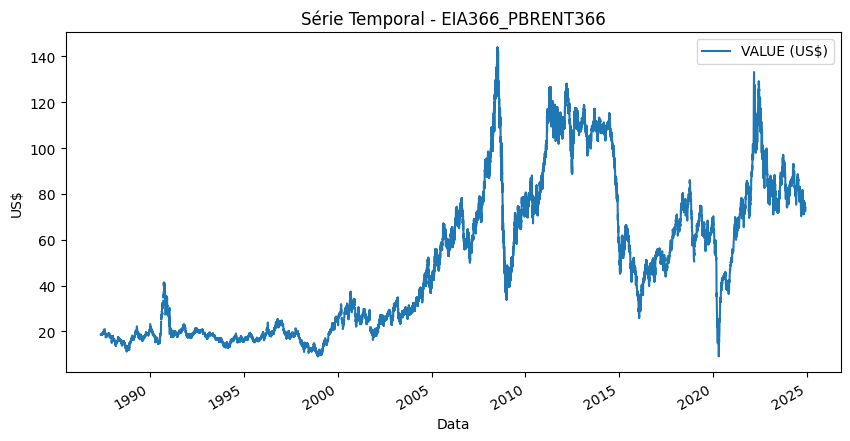

In [4]:
import matplotlib.pyplot as plt
eia366[["VALUE (US$)"]].plot(figsize=(10,5))
plt.title('Série Temporal - EIA366_PBRENT366')
plt.xlabel("Data")
plt.ylabel("US$")
plt.show()

# Extract

In [5]:
import ipeadatapy
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, date_format

spark = SparkSession.builder \
        .appName("ETL example") \
        .getOrCreate()

cod = "EIA366_PBRENT366"
eia366=ip.timeseries(cod)

df = spark.createDataFrame(eia366)

raw_data_path = "../data/raw"

df.write.mode("overwrite").parquet(raw_data_path)

24/12/07 14:33:28 WARN Utils: Your hostname, JarvisOne resolves to a loopback address: 127.0.1.1; using 192.168.0.76 instead (on interface wlp0s20f3)
24/12/07 14:33:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 14:33:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 14:33:38 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
24/12/07 14:33:38 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 84,47% for 8 writers
24/12/07 14:33:38 WARN MemoryManager: Total allocation exceeds 95,00% (906.992.014 bytes) of heap memory
Scaling row group sizes to 75,08% for 9 writers
24/12/07 14:33:38 WARN MemoryM

# Transform

In [6]:
from pyspark.sql.functions import (
    avg, col, concat, current_date, date_format,lag,lpad,max,min,quarter,stddev,to_date)

from pyspark.sql.window import Window


raw_data_path = "../data/raw"
df = spark.read.parquet(raw_data_path)


# obtendo o ano e mês corrente
current_year = date_format(current_date(), "yyyy").cast("int")
current_month = date_format(current_date(), "MM").cast("int")

# filtrando para remover os dados do mês corrente
df = df.filter(~((col("YEAR") == current_year) & (col("MONTH") == current_month)))

# removendo registros com valores ausentes em "VALUE (US$)"
df = df.na.drop(subset=["VALUE (US$)"])

# média mensal de preço do petróleo bruto
df = df.groupBy("YEAR", "MONTH").agg(avg("VALUE (US$)").alias("preco_medio_usd"))

# criação da coluna "anomes" utilizando os campos "YEAR" e "MONTH"
df = df.withColumn("anomes", to_date(concat(col("YEAR").cast("string"), lpad(col("MONTH").cast("string"), 2, "0")), "yyyyMM"))

# ordenando o DataFrame por data
window_spec = Window.orderBy("anomes")

# criando lags de 1 a 6 meses
df = df.withColumn("lag_1_mes_preco_medio_usd", lag("preco_medio_usd", 1).over(window_spec)) \
       .withColumn("lag_2_meses_preco_medio_usd", lag("preco_medio_usd", 2).over(window_spec)) \
       .withColumn("lag_3_meses_preco_medio_usd", lag("preco_medio_usd", 3).over(window_spec)) \
       .withColumn("lag_4_meses_preco_medio_usd", lag("preco_medio_usd", 4).over(window_spec)) \
       .withColumn("lag_5_meses_preco_medio_usd", lag("preco_medio_usd", 5).over(window_spec)) \
       .withColumn("lag_6_meses_preco_medio_usd", lag("preco_medio_usd", 6).over(window_spec))

# média móvel de 6 meses
df = df.withColumn("media_movel_6_meses_preco_medio_usd", avg(col("preco_medio_usd")).over(window_spec.rowsBetween(-6, -1)))

# desvio padrão móvel de 6 meses
df = df.withColumn("desvio_padrao_movel_6_meses_preco_medio_usd", stddev(col("preco_medio_usd")).over(window_spec.rowsBetween(-6, -1)))

# valor mínimo e máximo dos últimos 6 meses
df = df.withColumn("valor_minimo_6_meses_preco_medio_usd", min(col("preco_medio_usd")).over(window_spec.rowsBetween(-6, -1))) \
       .withColumn("valor_maximo_6_meses_preco_medio_usd", max(col("preco_medio_usd")).over(window_spec.rowsBetween(-6, -1)))

# componentes sazonais: ano, mês e trimestre
df = df.withColumn("trimestre", quarter("anomes"))
df = df.withColumnRenamed("YEAR", "ano")
df = df.withColumnRenamed("MONTH", "mes")

# remoção do campo "anomes"
df = df.drop("anomes")

# removendo linhas com valores NaN que foram criados ao fazer o shift ou nas agregações
df = df.dropna()

# persistindo os dados transformados
transformed_data_path = "../data/transformed"
df.write.mode("overwrite").parquet(transformed_data_path)

24/12/07 14:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 14:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 14:33:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 14:33:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 14:33:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 14:33:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/07 1

# Load

In [7]:
from pyspark.sql.types import DecimalType, IntegerType

# carregando os dados transformados
transformed_data_path = "../data/transformed"
df = spark.read.parquet(transformed_data_path)

# forçando os tipos de dados
df = df.select(
    col("ano").cast(IntegerType()),
    col("mes").cast(IntegerType()),
    col("preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_1_mes_preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_2_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_3_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_4_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_5_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("lag_6_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("media_movel_6_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("desvio_padrao_movel_6_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("valor_minimo_6_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("valor_maximo_6_meses_preco_medio_usd").cast(DecimalType(5,2)),
    col("trimestre").cast(IntegerType())
)

# persistindo os dados prontos para consumo
final_data_path = "../data/final"
df.write.mode("overwrite").parquet(final_data_path)